### Proyecto: Analitica de textos
#### Caso: Elegibilidad de pacientes para ensayos clinicos
#### Nicolás Orjuela

Para este proyecto, se escogio utilizar el modelo de máquinas de vectores de soporte (SVM) para determinar a los pacientes en si son elegibles o si no. Antes de poder entrenar el modelo se debe realizar un preprocesamiento exaustivo en donde se utilice el modelo de Bag of Words para la vectorización del texto, y despues realizar la lematización del mismo. 

**Este preprocesamiento es el mismo utilizado por Felipe Bedoya**

### 0. Importación de librerias

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)
import numpy as np
np.random.seed(3301)

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#para hacer balanceo de los features
from imblearn.over_sampling import SMOTE
# Para realizar la separaciond el conjunto de aprendizaje en entrenamiento y test
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para busqueda de hiperparametros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
#Librerias para la visualizacion
import matplotlib.pyplot as plt
#Seaborn
import seaborn as sns

import re

from sklearn.preprocessing import FunctionTransformer

import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


pd.set_option('display.max_colwidth', None)  # or 199

from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

from sklearn.pipeline import Pipeline

from sklearn import svm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\orjue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Preprocesamiento

Primero se deben cargar los datos y realizar un perfilamiento de estos, una vez se sabe el estado y pureza de los datos se pueden empezar a limpiar siguiendo lo establecido en el diccionario de datos

In [2]:
# Importe
df_eleg = pd.read_csv('../Datos/ElegibilidadEstudiantes/clinical_trials_on_cancer_data_clasificacion.csv', sep=',', encoding='utf-8', dtype='unicode')
df_eleg.head()

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurrent verrucous carcinoma of the larynx diagnosis and patients must agree to use adequate birth control for the duration of study participation and for at least eight weeks after discontinuation of study drug
1,__label__1,study interventions are Stem cell transplantation . hodgkin lymphoma diagnosis and history of congenital hematologic immunologic or metabolic disorder which in the estimation of the pi poses prohibitive risk to the recipient
2,__label__0,study interventions are Lenograstim . recurrent adult diffuse mixed cell lymphoma diagnosis and creatinine clearance crcl greater than fifty ml per minute all tests must be performed within twenty-eight days prior to registration
3,__label__0,study interventions are Doxorubicin . stage iii diffuse large cell lymphoma diagnosis and stages ii bulky disease defined as mass size of more than ten cm stage iii or iv ann_arbor staging patients with stage and stage ii non bulky disease are excluded from this study
4,__label__1,study interventions are Poly I-C . prostate cancer diagnosis and unresolved iraes following prior biological therapy except that stable and managed iraes may be acceptable hypothyroidism or hypopituitarism on appropriate replacement


Vemos si existen datos nulos en el dataset:

In [3]:
df_eleg.isna().sum()

label                  0
study_and_condition    0
dtype: int64

Los datos no tienen nulos pero estan presentados de maneras distintas. Algunos comienzan con comillas, otros son espacios. Debemos lograr entradas similares. Adicionalmente la informacion importante del paciente esta ubicada despues del primer punto. Adicionalmente vemos que los labels son categoricos y debemos volverlos numericos. Aunque un label encoder haria esta tarea con facilidad, queremos conservar la categoria implicita que ya traen.

In [4]:
def preprocessor(df):
    df= df.replace('""', '')
    df = df.str.strip(' ')
    df = df.str.split('.').str[1]
    return df
print(df_eleg.describe())

def encoder(df):
    df.loc[df['label'] == '__label__0', 'label'] = 0
    df.loc[df['label'] == '__label__1', 'label'] = 1
encoder(df_eleg)
df_eleg

             label  \
count        12000   
unique           2   
top     __label__0   
freq          6000   

                                                                             study_and_condition  
count                                                                                      12000  
unique                                                                                     11987  
top     study interventions are Fludarabine . anaplastic large cell lymphoma diagnosis and donor  
freq                                                                                           2  


,label,study_and_condition
0,0,study interventions are Saracatinib . recurrent verrucous carcinoma of the larynx diagnosis and patients must agree to use adequate birth control for the duration of study participation and for at least eight weeks after discontinuation of study drug
1,1,study interventions are Stem cell transplantation . hodgkin lymphoma diagnosis and history of congenital hematologic immunologic or metabolic disorder which in the estimation of the pi poses prohibitive risk to the recipient
2,0,study interventions are Lenograstim . recurrent adult diffuse mixed cell lymphoma diagnosis and creatinine clearance crcl greater than fifty ml per minute all tests must be performed within twenty-eight days prior to registration
3,0,study interventions are Doxorubicin . stage iii diffuse large cell lymphoma diagnosis and stages ii bulky disease defined as mass size of more than ten cm stage iii or iv ann_arbor staging patients with stage and stage ii non bulky disease are excluded from this study
4,1,study interventions are Poly I-C . prostate cancer diagnosis and unresolved iraes following prior biological therapy except that stable and managed iraes may be acceptable hypothyroidism or hypopituitarism on appropriate replacement
...,...,...
11995,0,study interventions are Prednisolone hemisuccinate . recurrent childhood large cell lymphoma diagnosis and no known hypersensitivity to etanercept
11996,0,"study interventions are Bevacizumab . recurrent rectal cancer diagnosis and absolute neutrophil count greater_than equal_than one thousand, five hundred ul"
11997,1,"study interventions are Antibodies, Monoclonal . recurrent lymphoblastic lymphoma diagnosis and and intrathecal intraventricular therapy"
11998,0,study interventions are Vorinostat . colorectal cancer diagnosis and patients must have received at least one prior chemotherapy regimen for advanced disease


Creamos el pipeline para facilitar el uso del modelo en produccion.

In [5]:
pre = [('preproc', FunctionTransformer(preprocessor))]

Ahora vamos a preprocesar el texto partiendolo en tokens y lematizandolo. Despues se utilizar un modelo de bag of words y finalmente tf-idf para identificar las palabras importantes. Aprovechamos el corpus de nltk para quitar palabras conectoras que generen ruido.

In [6]:
porter = PorterStemmer()
stop = stopwords.words('english')
def tokenizer_porter(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter.stem(token) for token in tokens if token not in stop]
    return ' '.join(stemmed_tokens)

def transformer_tokenizer(df):
    df = df.apply(tokenizer_porter)
    return df

pre += [('porter', FunctionTransformer(transformer_tokenizer))]

In [7]:
df_eleg

,label,study_and_condition
0,0,study interventions are Saracatinib . recurrent verrucous carcinoma of the larynx diagnosis and patients must agree to use adequate birth control for the duration of study participation and for at least eight weeks after discontinuation of study drug
1,1,study interventions are Stem cell transplantation . hodgkin lymphoma diagnosis and history of congenital hematologic immunologic or metabolic disorder which in the estimation of the pi poses prohibitive risk to the recipient
2,0,study interventions are Lenograstim . recurrent adult diffuse mixed cell lymphoma diagnosis and creatinine clearance crcl greater than fifty ml per minute all tests must be performed within twenty-eight days prior to registration
3,0,study interventions are Doxorubicin . stage iii diffuse large cell lymphoma diagnosis and stages ii bulky disease defined as mass size of more than ten cm stage iii or iv ann_arbor staging patients with stage and stage ii non bulky disease are excluded from this study
4,1,study interventions are Poly I-C . prostate cancer diagnosis and unresolved iraes following prior biological therapy except that stable and managed iraes may be acceptable hypothyroidism or hypopituitarism on appropriate replacement
...,...,...
11995,0,study interventions are Prednisolone hemisuccinate . recurrent childhood large cell lymphoma diagnosis and no known hypersensitivity to etanercept
11996,0,"study interventions are Bevacizumab . recurrent rectal cancer diagnosis and absolute neutrophil count greater_than equal_than one thousand, five hundred ul"
11997,1,"study interventions are Antibodies, Monoclonal . recurrent lymphoblastic lymphoma diagnosis and and intrathecal intraventricular therapy"
11998,0,study interventions are Vorinostat . colorectal cancer diagnosis and patients must have received at least one prior chemotherapy regimen for advanced disease


Ahora utilizamos el modelo Bag of Words para traducir el texto a un vector numerico que representa las palabras en el mismo. Como la frecuencia de las palabras no importantes tiende a ser elevado entonces utilizamos tfidf para corregirlo.

In [8]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
pre += [('tfidf', tfidf)]

### 2. Modelamiento y entrenamiento del modelo

Ya con los datos preprocesados y listos para analizar, se procede a crear los datos de entrenamiento y validacion y a entrenar el modelo SVM.

In [9]:
Y = df_eleg['label'].astype('int')
X = df_eleg['study_and_condition']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 98572398)

Se hace un GridSearch para encontrar los mejores hiperparametros para el modelo

In [11]:
model = [('SVM', svm.SVC())]
pipeline = Pipeline(pre+model)
  
# defining parameter range
param_grid = {'SVM__C': [0.001, 0.1, 1, 10, 100], 
              'SVM__gamma': [1, 0.1, 0.01],
              'SVM__kernel': ['linear','poly','rbf']} 
  
grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 1, cv=15)
grid_search=grid.fit(X_train, Y_train)

Fitting 15 folds for each of 45 candidates, totalling 675 fits


In [12]:
SVM = grid_search.best_estimator_

In [13]:
print(grid_search.best_params_)

{'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'poly'}


Hacemos una matriz de confusion para observar que tan bien esta clasificando los datos el modelo

C:\Users\orjue\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


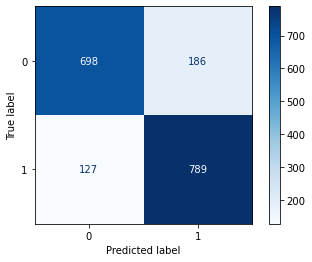

In [26]:
y_test_hat=grid.predict(X_test)
confusion_matrix(Y_test,y_test_hat)
disp=plot_confusion_matrix(grid, X_test, Y_test,cmap=plt.cm.Blues)

In [22]:
print('CV Accuracy: %.3f' % grid.best_score_)

print('Test Accuracy: %.3f' % SVM.score(X_test, Y_test))

CV Accuracy: 0.820
Test Accuracy: 0.826
